# Station Air Pollution Estimation

For each station, find a good model to predict the individual pollutants.

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
metrics = [root_mean_squared_error, r2_score, mean_absolute_error]

from utils import *

datasets_folder = './datasets'
verbosity=0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Import

We will only focus on the station with the most agents, Porta San Felice.

In [2]:
san_felice_pollution_dict = read_and_preprocess_dataset(datasets_folder, 'pollution', resample=False, v=verbosity)[1]
san_felice_traffic_df = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity)[1]
weather_df = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

In [82]:
san_felice_data = prepare_station_data_for_training(san_felice_pollution_dict, san_felice_traffic_df, weather_df
                                                    # , encoding_method='radial_months_days-sin-cos_hours'
                                                    , encoding_method='radial_months-sin-cos_days_hours'
                                                    )
print(*list(san_felice_data.keys()), sep=', ')
# list(san_felice_data.values())[0].head(5)

C6H6, CO, NO, NO2, NOX, PM10, PM2.5


## Models

For each station we develop a model to describe the air pollution. Given that each station collects different data, and sometimes with different intensities, we decided to treat each station indepentendtely.

Air polution follows this criteria:
- for each pollutant a certain limit is defined (like 25 µg/m³ for PM2.5)
- for each pollutant $ AQI = \frac{Concentration}{Limit} \times 100 $
- take the maximum value across all the IQAs 

The overage value is then matched on the following table:

| **AQI**         | **CONDITIONS** |
| --------------- | -------------- |
| <30             | EXCELLENT      |
| From 34 to 66   | GOOD           |
| From 67 to 99   | FAIR           |
| From 99 to 150  | POOR           |
| >150            | VERY POOR      |

We are going to model each agent to predict its hour value and then use all of the predictions to compute the overall Air Quality Index and compare it with the one got from the readings.

In [56]:
pollutant_limits = {
    'PM2.5': 25,    # µg/m³
    'PM10': 50,     # µg/m³
    'CO': 10,       # mg/m³
    'O3': 180,      # µg/m³
    'NO': None,     # µg/m³
    'NO2': 200,     # µg/m³
    'NOX': None,    # µg/m³
    'C6H6': None    # µg/m³
}

In [57]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

From the first notebook:
- Agent C6H6: 3675 *(0.0699%)* missing Values
- Agent CO: 821 *(0.0156%)* missing Values
- Agent NO: 1056 *(0.0201%)* missing Values
- Agent NO2: 1056 *(0.0201%)* missing Values
- Agent NOX: 940 *(0.0179%)* missing Values
- Agent PM10: 57 *(0.0260%)* missing Values
- Agent PM2.5: 54 *(0.0246%)* missing Values

We focus on CO beacuse it has the least missing values.

### **Estimations**

In [83]:
co_x_train, co_y_train, co_x_test, co_y_test = create_train_test(san_felice_data['PM10'], train_split_date, y=target)

#### **Random Forest Regressor**

In [84]:
from sklearn.ensemble import RandomForestRegressor

co_rand_forest = RandomForestRegressor(n_estimators=100,max_depth=10,random_state=42)

co_rand_forest.fit(co_x_train,co_y_train[target])

RandomForestRegressor(max_depth=10, random_state=42)

In [85]:
co_y_pred_rf = co_rand_forest.predict(co_x_test)
co_y_pred_df_rf = pd.DataFrame(co_y_pred_rf, index=co_y_test.index) # serve perchè le predizioni partono da zero, ma y_test ha ancora gli indici giusti

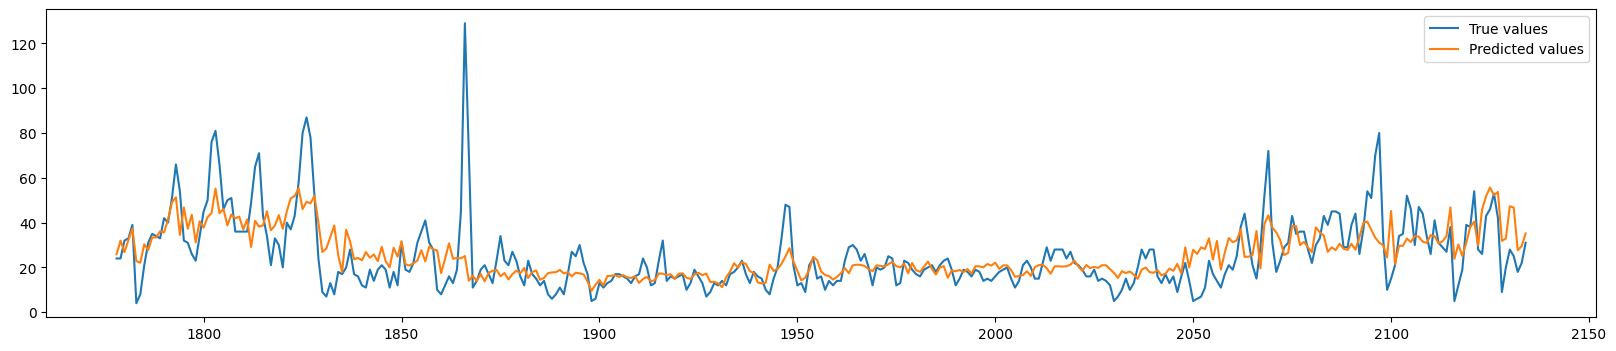

In [86]:
plt.figure(figsize=(20,4))
plt.plot(co_y_test.iloc[:500], label='True values')
plt.plot(co_y_pred_df_rf.iloc[:500], label='Predicted values')
plt.legend()
plt.show()

#### **LSTM**

In [113]:
def build_model(in_shape,
                optimizer='adam',
                loss='mse'
                ):
    model = Sequential([
        LSTM(100, return_sequences=False, input_shape=(in_shape[1], in_shape[2])),
        # Dropout(0.2),
        # LSTM(50, return_sequences=False),
        # Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

In [114]:
def create_sequences(x_df, y_df, time_steps=10):
    X, y = [], []
    for i in range(len(x_df) - time_steps):
        X.append(x_df.iloc[i:i+time_steps].values)
        y.append(y_df.iloc[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 1  # Use past 30 hours for prediction
feature_cols = co_x_train.columns.tolist()

co_x_train_seq, co_y_train_seq = create_sequences(co_x_train, co_y_train, time_steps)
co_x_test_seq, co_y_test_seq = create_sequences(co_x_test, co_y_test, time_steps)

In [115]:
tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [116]:
co_lstm = build_model(co_x_train_seq.shape,  optimizer=Adam(learning_rate=1e-2), loss='mean_absolute_error')
co_lstm.fit(
    co_x_train_seq,
    co_y_train_seq,
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
56/56 [==============================] - 1s 2ms/step - loss: 13.1691
Epoch 2/10
56/56 [==============================] - 0s 2ms/step - loss: 8.8200
Epoch 3/10
56/56 [==============================] - 0s 1ms/step - loss: 8.6496
Epoch 4/10
56/56 [==============================] - 0s 2ms/step - loss: 8.5514
Epoch 5/10
56/56 [==============================] - 0s 1ms/step - loss: 8.5700
Epoch 6/10
56/56 [==============================] - 0s 1ms/step - loss: 8.7140
Epoch 7/10
56/56 [==============================] - 0s 1ms/step - loss: 8.4686
Epoch 8/10
56/56 [==============================] - 0s 2ms/step - loss: 8.4063
Epoch 9/10
56/56 [==============================] - 0s 1ms/step - loss: 8.5247
Epoch 10/10
56/56 [==============================] - 0s 2ms/step - loss: 8.4072


In [117]:
co_y_pred_lstm = co_lstm.predict(co_x_test_seq)
co_y_pred_df_lstm = pd.DataFrame(co_y_pred_lstm, index=co_y_test.index[time_steps:])

12/12 [==============================] - 0s 909us/step


In [118]:
# co_lstm2 = build_model(co_x_train_seq.shape,  optimizer=Adam(learning_rate=1e-2), loss='mean_absolute_error')
# co_lstm2.fit(
#     co_x_train_seq,
#     co_y_train_seq,
#     epochs=10,
#     batch_size=32,
#     verbose=1
# )
# co_y_pred_lstm2 = co_lstm2.predict(co_x_test_seq)
# co_y_pred_df_lstm2 = pd.DataFrame(co_y_pred_lstm2, index=co_y_test.index[time_steps:])

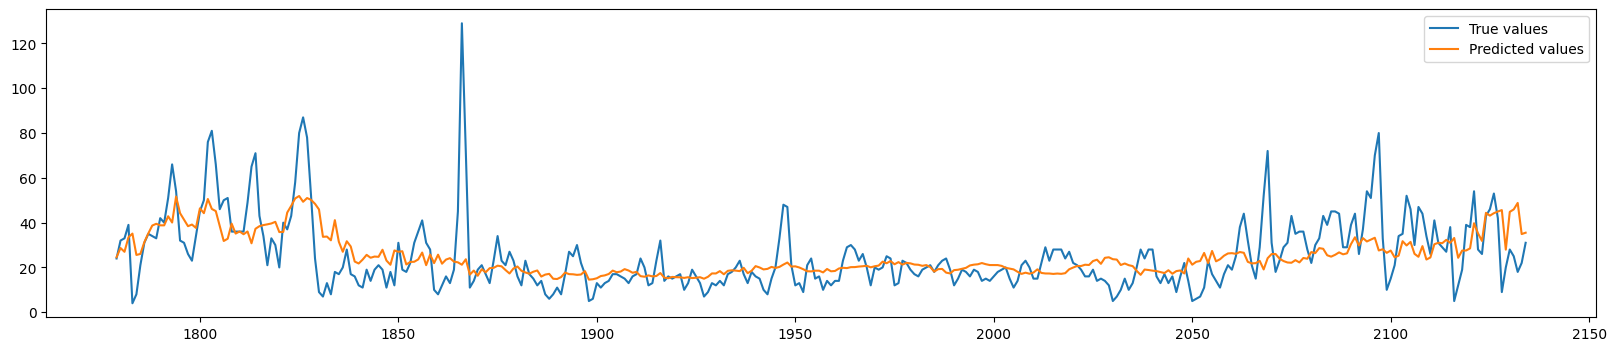

root_mean_squared_error: 13.247118478014041
r2_score: 0.3066501971335728
mean_absolute_error: 8.818612779124399


In [119]:
plt.figure(figsize=(20,4))
plt.plot(co_y_test.iloc[time_steps:], label='True values')
plt.plot(co_y_pred_df_lstm, label='Predicted values')
plt.legend()
plt.show()

for m in metrics:
    score = m(co_y_test.iloc[time_steps:],co_y_pred_df_lstm)
    print(f'{m.__name__}: {score}')

#### **Feed Forward Neural Network**

In [94]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [95]:
def build_ffnn(in_shape,
               optimizer='adam',
               loss='mse'):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(in_shape,)),
        Dropout(0.2),
        Dense(512, activation='relu'), 
        Dropout(0.2),
        Dense(256, activation='relu'),  
        Dropout(0.2),
        Dense(128, activation='relu'),  
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

in_shape = len(co_x_train.columns)


In [96]:
co_ffnn = build_ffnn(in_shape, optimizer=Adam(learning_rate=1e-2),loss='mean_absolute_error')
# print(co_ffnn.summary()) 
co_ffnn.fit(co_x_train, co_y_train, epochs=10, batch_size=32)

Epoch 1/10
56/56 [==============================] - 1s 4ms/step - loss: 15.2890
Epoch 2/10
56/56 [==============================] - 0s 5ms/step - loss: 9.7670
Epoch 3/10
56/56 [==============================] - 0s 4ms/step - loss: 9.7233
Epoch 4/10
56/56 [==============================] - 0s 4ms/step - loss: 9.4614
Epoch 5/10
56/56 [==============================] - 0s 4ms/step - loss: 9.0694
Epoch 6/10
56/56 [==============================] - 0s 5ms/step - loss: 8.7528
Epoch 7/10
56/56 [==============================] - 0s 5ms/step - loss: 9.0422
Epoch 8/10
56/56 [==============================] - 0s 4ms/step - loss: 8.4950
Epoch 9/10
56/56 [==============================] - 0s 4ms/step - loss: 8.4715
Epoch 10/10
56/56 [==============================] - 0s 4ms/step - loss: 8.7037


In [97]:
co_y_pred_ffnn = co_ffnn.predict(co_x_test)
co_y_pred_df_ffnn = pd.DataFrame(co_y_pred_ffnn, index=co_y_test.index) # serve perchè le predizioni partono da zero, ma y_test ha ancora gli indici giusti

12/12 [==============================] - 0s 1ms/step


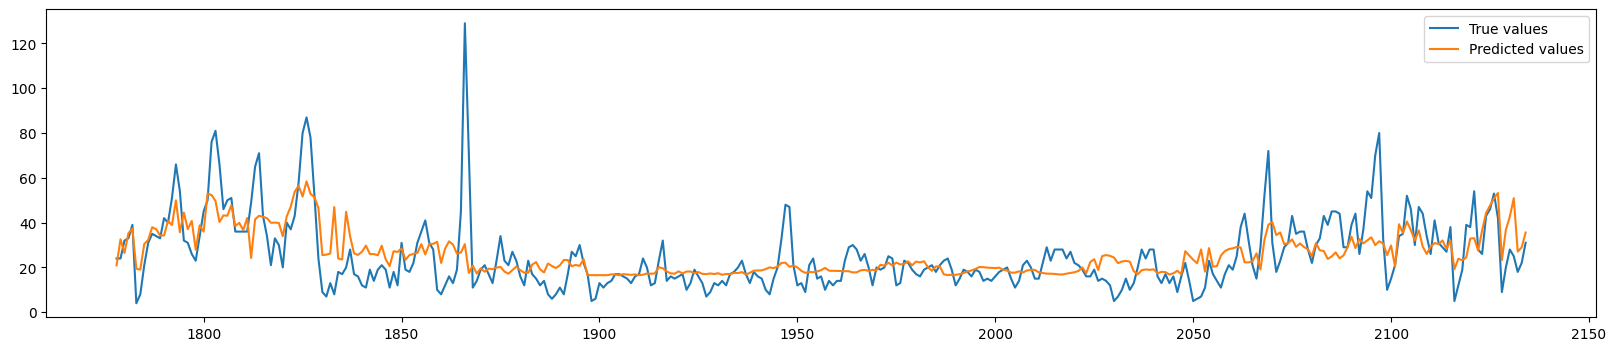

root_mean_squared_error: 12.280563708211746
r2_score: 0.40247396256936174
mean_absolute_error: 8.352029538622089


In [98]:
plt.figure(figsize=(20,4))
plt.plot(co_y_test, label='True values')
plt.plot(co_y_pred_df_ffnn, label='Predicted values')
plt.legend()
plt.show()
for m in metrics:
    score = m(co_y_test,co_y_pred_df_ffnn)
    print(f'{m.__name__}: {score}')

#### **XGBoost**

In [99]:
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    # max_depth=20
    )
model.fit(co_x_train, co_y_train)

co_y_pred_xgb = model.predict(co_x_test)
co_y_pred_df_xgb = pd.DataFrame(co_y_pred_xgb, index=co_y_test.index)

### Comparison

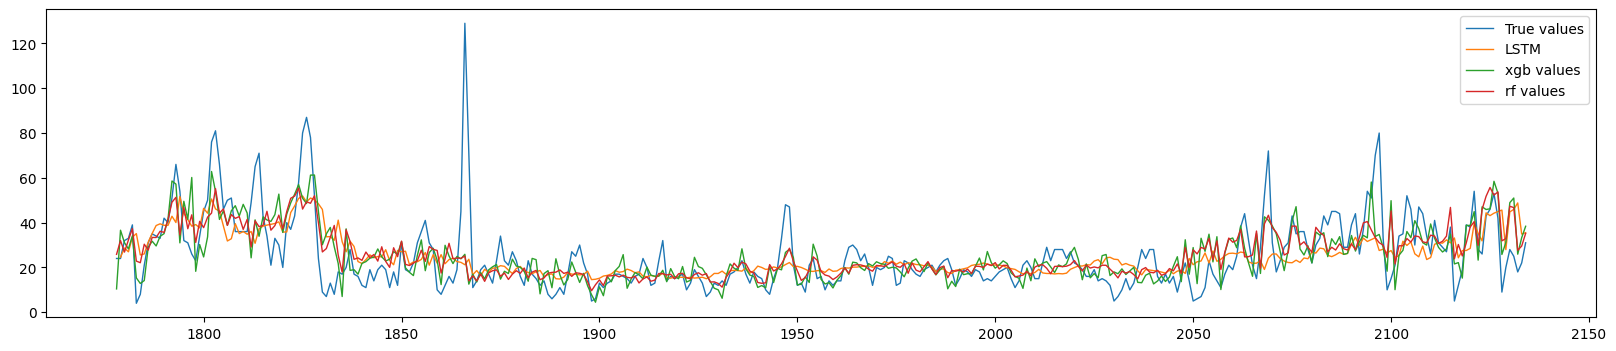

root_mean_squared_error:
 - LSTM: 13.247118478014041
 - FFNN: 12.280563708211746
 - XGB: 12.533341487171153
 - RF: 12.298082486889083
r2_score:
 - LSTM: 0.3066501971335728
 - FFNN: 0.40247396256936174
 - XGB: 0.37762236903035606
 - RF: 0.4007679508361147
mean_absolute_error:
 - LSTM: 8.818612779124399
 - FFNN: 8.352029538622089
 - XGB: 8.369451056675416
 - RF: 8.042634334303893


In [120]:
samples = 365
offset =  31 * 0

plt.figure(figsize=(20,4))
plt.plot(co_y_test.iloc[offset:samples+offset], label='True values', linewidth=1)
plt.plot(co_y_pred_df_lstm.iloc[offset:samples+offset], label='LSTM', linewidth=1)
# plt.plot(co_y_pred_df_lstm2.iloc[offset:samples+offset], label='LSTM 2', linewidth=1)
# plt.plot(co_y_pred_df_ffnn.iloc[offset:samples+offset], label='ffnn values', linewidth=1)
plt.plot(co_y_pred_df_xgb.iloc[offset:samples+offset], label='xgb values', linewidth=1)
plt.plot(co_y_pred_df_rf.iloc[offset:samples+offset], label='rf values', linewidth=1)
# plt.xlim(co_y_test.index[0],co_y_test.index[-1])
plt.legend()
plt.show()

for m in metrics:
    score_lstm = m(co_y_test.iloc[time_steps:],co_y_pred_df_lstm)
    # score_lstm2 = m(co_y_test.iloc[time_steps:],co_y_pred_df_lstm2)
    score_ffnn = m(co_y_test,co_y_pred_df_ffnn)
    score_xgb = m(co_y_test,co_y_pred_df_xgb)
    score_rf = m(co_y_test,co_y_pred_df_rf)
    print(f'{m.__name__}:')
    print(f' - LSTM: {score_lstm}')
    # print(f' - LSTM: {score_lstm2}')
    print(f' - FFNN: {score_ffnn}')
    print(f' - XGB: {score_xgb}')
    print(f' - RF: {score_rf}')

root_mean_squared_error:
 - LSTM: 16.78633500788745
 - FFNN: 19.03708320763799
 - XGB: 17.417460042310967
 - RF: 17.503213839929646
r2_score:
 - LSTM: 0.4733509604003272
 - FFNN: 0.32231664786655956
 - XGB: 0.4327223850036688
 - RF: 0.4271227208748478
mean_absolute_error:
 - LSTM: 9.77946031315951
 - FFNN: 10.238628302283821
 - XGB: 10.025702926055418
 - RF: 9.510767515911347

['Traffic_value', 'TAVG', 'PREC', 'RHAVG', 'RAD', 'W_SCAL_INT', 'W_VEC_DIR', 'W_VEC_INT', 'LEAFW', 'ET0']


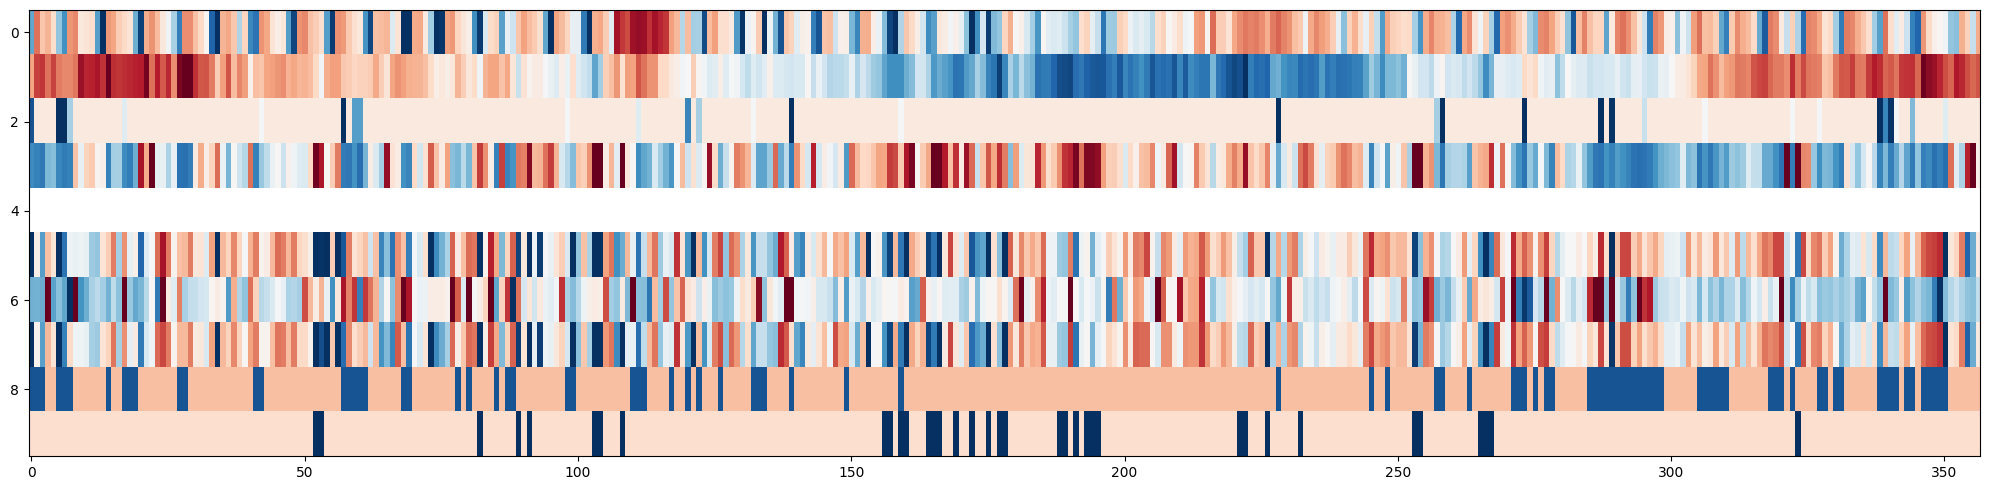

In [102]:
cols=co_x_test.columns[:10]
hpcsv = co_x_test[cols].copy()
hpcsv = (hpcsv - hpcsv.mean()) / hpcsv.std()
plot_dataframe(hpcsv[offset:samples+offset])
print([c for c in cols])

In [77]:
co_y_pred_lstm_train = co_lstm.predict(co_x_train_seq)
co_y_pred_df_lstm_train = pd.DataFrame(co_y_pred_lstm_train, index=co_y_train.index[time_steps:])

co_y_pred_ffnn_train = co_ffnn.predict(co_x_train)
co_y_pred_df_ffnn_train = pd.DataFrame(co_y_pred_ffnn_train, index=co_y_train.index) 

1343/1343 [==============================] - 2s 1ms/step


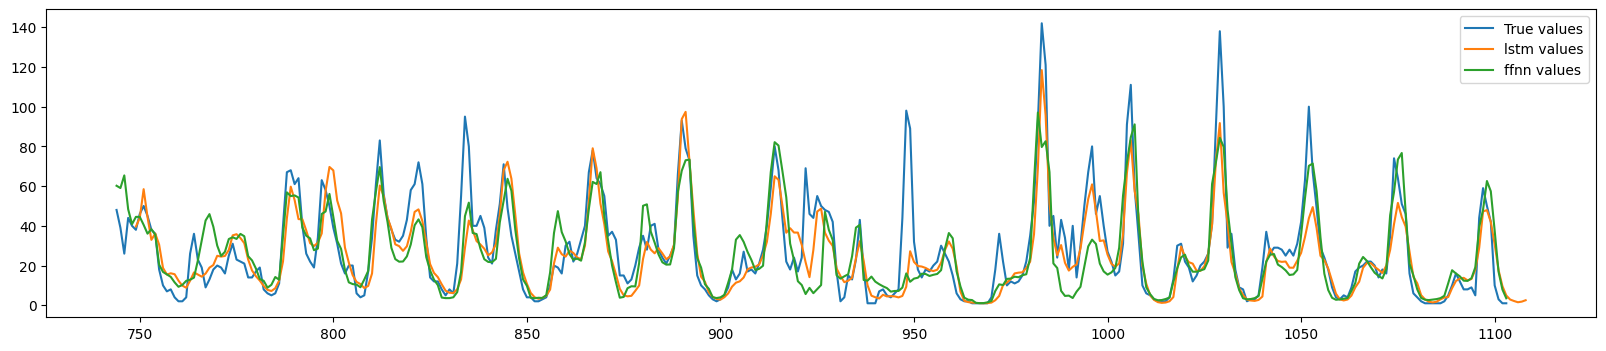

root_mean_squared_error:
 - LSTM: 12.913079940672672
 - FFNN: 15.309223833152833
r2_score:
 - LSTM: 0.6920436581439495
 - FFNN: 0.5676927049875149
mean_absolute_error:
 - LSTM: 6.428883090441418
 - FFNN: 7.685955406784184


In [78]:
samples = 24 * 15
offset = 24 * 31 * 1

plt.figure(figsize=(20,4))
plt.plot(co_y_train.iloc[offset:samples+offset], label='True values')
plt.plot(co_y_pred_df_lstm_train.iloc[offset:samples+offset], label='lstm values')
plt.plot(co_y_pred_df_ffnn_train.iloc[offset:samples+offset], label='ffnn values')
plt.legend()
plt.show()

for m in metrics:
    score_lstm = m(co_y_train.iloc[time_steps:],co_y_pred_df_lstm_train)
    score_ffnn = m(co_y_train,co_y_pred_df_ffnn_train)
    print(f'{m.__name__}:\n - LSTM: {score_lstm}\n - FFNN: {score_ffnn}')